In [2]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [3]:
model = VGG16(weights='imagenet', include_top=True)

553476096/553467096 [==============================] - 13s 0us/step


In [4]:
print(model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

shape of x:  (1, 224, 224, 3)
data type:  float32


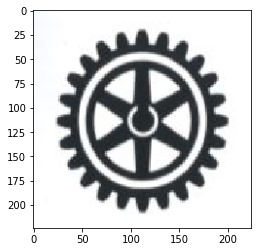

In [6]:
img, x = load_image("/content/drive/MyDrive/Actual_Data/TM-Data/102788733.JPG")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

In [7]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

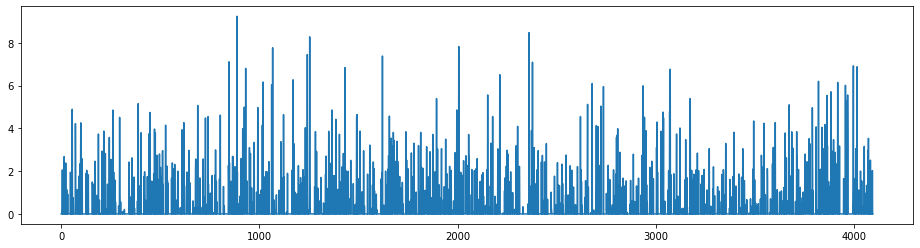

In [8]:
img, x = load_image("/content/drive/MyDrive/Actual_Data/TM-Data/102788733.JPG")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [9]:
images_path = '/content/drive/MyDrive/Actual_Data/TM-Data'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 3146 images to analyze


In [10]:
import time
tic = time.clock()


features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


analyzing image 0 / 3146. Time: 0.0003 seconds.
analyzing image 500 / 3146. Time: 31.0897 seconds.
analyzing image 1000 / 3146. Time: 28.8694 seconds.
analyzing image 1500 / 3146. Time: 28.6096 seconds.
analyzing image 2000 / 3146. Time: 29.4928 seconds.
analyzing image 2500 / 3146. Time: 28.4733 seconds.
analyzing image 3000 / 3146. Time: 29.1269 seconds.
finished extracting features for 3146 images


In [11]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

PCA(n_components=300)

In [12]:
pca_features = pca.transform(features)

In [14]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

In [15]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:11]

In [17]:
def get_closest_images(query_image_idx, num_results=10):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

In [18]:
def get_concatenated_images2(indexes, thumb_height):
    RESULTS_ARRAY = []
    for count,idx in enumerate(indexes):
        img = image.load_img(images[idx])
        filename = (images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        # img.save(f"/content/drive/MyDrive/img_save/{count}.png")
        RESULTS_ARRAY.append(filename[43:])
    print('done')
    return RESULTS_ARRAY

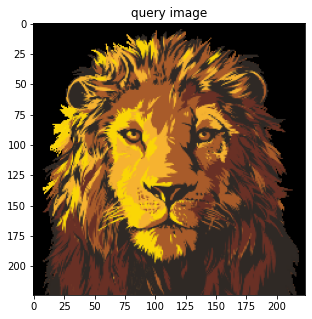

In [21]:
# load image and extract features
new_image, x = load_image('/content/drive/MyDrive/DemoData/lionBeer_header_v2.png')
new_features = feat_extractor.predict(x)

# project it into pca space
new_pca_features = pca.transform(new_features)[0]

# calculate its distance to all the other images pca feature vectors
distances = [ distance.cosine(new_pca_features, feat) for feat in pca_features ]
idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[0:5]  # grab first 10
results_image = get_concatenated_images(idx_closest, 200)

# display the results
plt.figure(figsize = (5,5))
plt.title("query image")
plt.imshow(new_image)

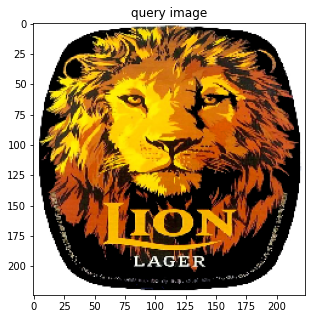

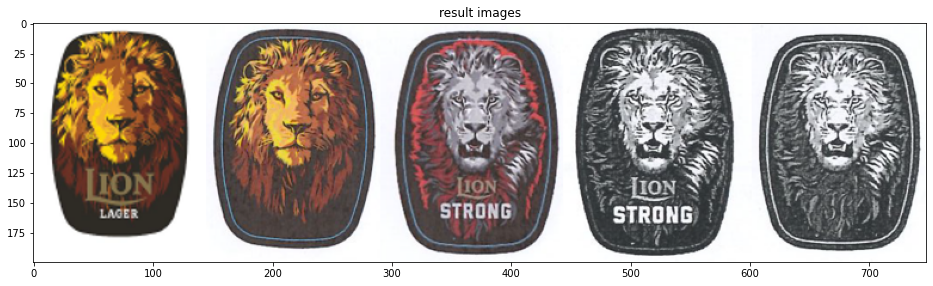

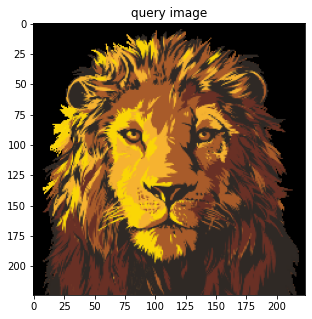

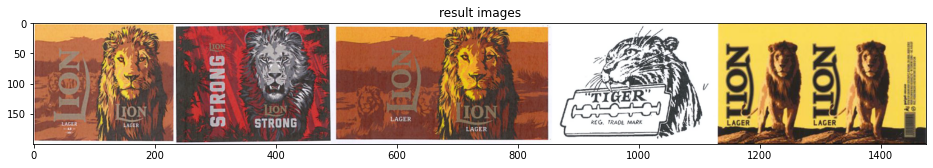

In [27]:
# load folder image and extract features

from os import listdir
from PIL import Image as PImage
import argparse
import glob
import cv2
import imutils

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()

path = "/content/drive/MyDrive/DemoData/"

files = os.listdir("/content/drive/MyDrive/DemoData/")
RESULTS = []
for file in files:
    # make sure file is an image
    if file.endswith(('.jpg', '.png', '.jpeg')):
        img_path = path + file
        new_image, x = load_image(img_path)
        new_features = feat_extractor.predict(x)

        new_features = feat_extractor.predict(x)

        # project it into pca space
        new_pca_features = pca.transform(new_features)[0]

        # calculate its distance to all the other images pca feature vectors
        distances = [ distance.cosine(new_pca_features, feat) for feat in pca_features ]
        idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[0:5]  # grab first 5
        results_image = get_concatenated_images(idx_closest, 200)

        # display the results
        plt.figure(figsize = (5,5))
        plt.title("query image")
        plt.imshow(new_image)

        # display the resulting images
        plt.figure(figsize = (16,12))
        plt.title("result images")
        plt.imshow(results_image)

In [ ]:
import pickle

pickle.dump([images, pca_features, pca], open('/content/drive/MyDrive/FYP_Index/features_tm.p', 'wb'))